In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.util import img_as_float64
#from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from sklearn.linear_model import LinearRegression

In [11]:
import joblib
filename = '/content/drive/My Drive/Colab Notebooks/Image Colorization/Final_LR_v_channel.sav'
u_LR = joblib.load(filename)

filename2 = '/content/drive/My Drive/Colab Notebooks/Image Colorization/Final_LR_v_channel.sav'
v_LR = joblib.load(filename2)

In [12]:
K = 200     #no of. segment
m = 10      #compactness[1,40]
sqr = 10    #10*10 pixel around each center
rgb2yuv = np.array([[0.299, 0.587, 0.114],
                 [-0.14713, -0.28886, 0.436],
                 [0.615, -0.51499, -0.10001]]).T

yuv2rgb = np.array([[1, 0, 1.13983],
                 [1, -0.39465, -.58060],
                 [1, 2.03211, 0]]).T

In [13]:
def read_image(path):
    imr=imread(path)
    #print(imr.shape)
    newsize = (500, 600)
    image_resized = resize(imr, (newsize),anti_aliasing=True)
    #print(image_resized.shape)
    img = img_as_float64(image_resized)
    #plt.imshow(img)
    return img

In [14]:
def SLIC_superpixel(img,K,m):
    seg = slic(img, K, m, sigma=1)
    return seg

In [15]:
def feature_Extract(img,seg):
    yuv = np.dot(img,rgb2yuv) #convert YUV color space. Where, U and V are the chrominance
                              #luminance is denoted by Y
    mx_seg = seg.max() + 1

    total_point = np.zeros(mx_seg)
    center = np.zeros((mx_seg, 2))
    Y = np.zeros(mx_seg)
    U = np.zeros(mx_seg)
    V = np.zeros(mx_seg)
    #print(mx_seg)

    for (i,j), val in np.ndenumerate(seg):
        #print(i,j,value)
        total_point[val] += 1
        center[val][0] += i
        center[val][1] += j
        #Y[val] += yuv[i][j][0]
        U[val] += yuv[i][j][1]
        V[val] += yuv[i][j][2]

    for i in range(mx_seg):
        center[i] /= total_point[i]
        #Y[i] /= total_point[i]
        U[i] /= total_point[i]
        V[i] /= total_point[i]
    #print(center)

    feature_1 = yuv
    for (i,j),val in np.ndenumerate(seg):
        #feature_1[i][j][0] = Y[val]
        feature_1[i][j][1] = U[val]
        feature_1[i][j][2] = V[val]
    #imshow(feature_1)

    feature_1 = img_as_float64(feature_1)
    feature_2 = feature_1
    mx1,mx2 = 0,0
    eta = 20
    for (i,j),val in np.ndenumerate(feature_1[:,:0]):
      for j in range(600):
        v,v2,v3,point=0.0,0.0,0.0
        for x in range(eta):
          if(x+i>=500):
            break;
          for y in range(eta):
            if(y+j>=600):
              break;
            #v = v + feature_1[i+x][j+y][0]
            v2 = v2 + feature_1[i+x][j+y][1]
            v3 = v3 + feature_1[i+x][j+y][2]
            point = point+1.0
        #feature_2[i][j][0] = v/point
        feature_2[i][j][1] = v2/point
        feature_2[i][j][2] = v3/point
    #imshow(feature_2)

    feature = np.zeros((mx_seg, (sqr)**2))
    #print(feature)

    R = img.shape[0]
    C = img.shape[1]
    for k in range(mx_seg):
        row = int(center[k][0])
        col = int(center[k][1])
        for i in range(0, sqr):
            if(i+row>=R):
                break
            for j in range(0, sqr):
                if(j+col>=C):
                  break;
                feature[k][i*sqr + j] = feature_2[i + row][j + col][0]
    #feature = np.reshape(feature, (mx_seg*100))
    return feature,U,V

In [16]:
def testRun(directory):
    img = read_image(directory)
    
    print(img.shape)
    gray_img = rgb2gray(img)
    print(gray_img.shape)
    channel_3_img = np.zeros_like(img)
    channel_3_img[:,:,0] = gray_img
    channel_3_img[:,:,1] = gray_img
    channel_3_img[:,:,2] = gray_img

    seg = SLIC_superpixel(channel_3_img,K,m)

    feature,U,V = feature_Extract(channel_3_img,seg)
    yuv = np.dot(channel_3_img,rgb2yuv)
    #Predict using Linear Regression
    predict_u = (u_LR.predict(feature))
    predict_v = (v_LR.predict(feature))

    # Reconstruct images
    for (i,j), val in np.ndenumerate(seg):
        yuv[i][j][1] = predict_u[val]
        yuv[i][j][2] = predict_v[val]
    rgb = np.dot(yuv, yuv2rgb)
    return rgb,img

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


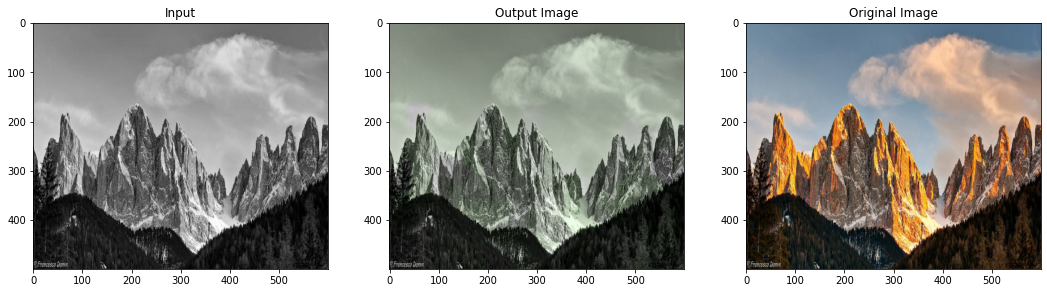

In [18]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/(6).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


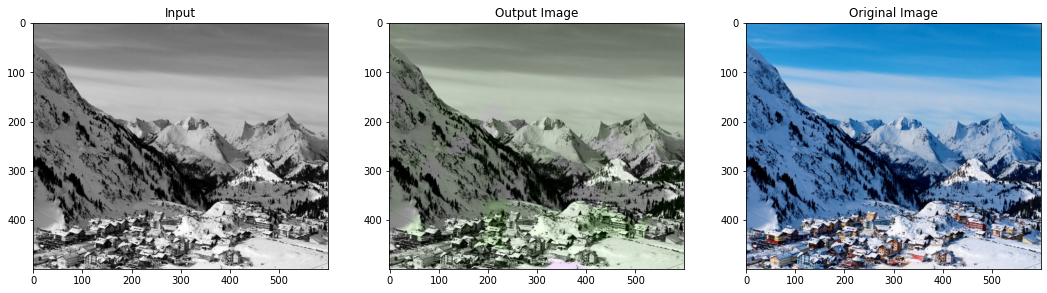

In [19]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/(7).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


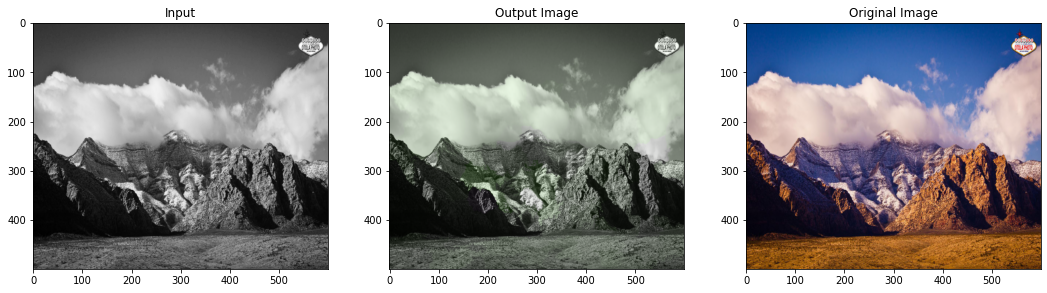

In [21]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/(15).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


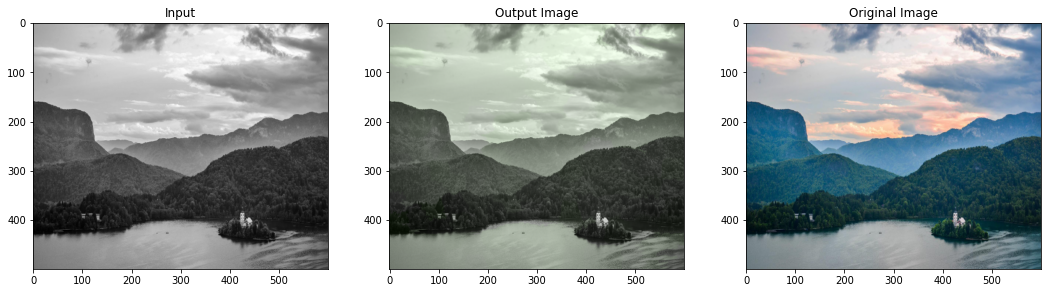

In [20]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/(8).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


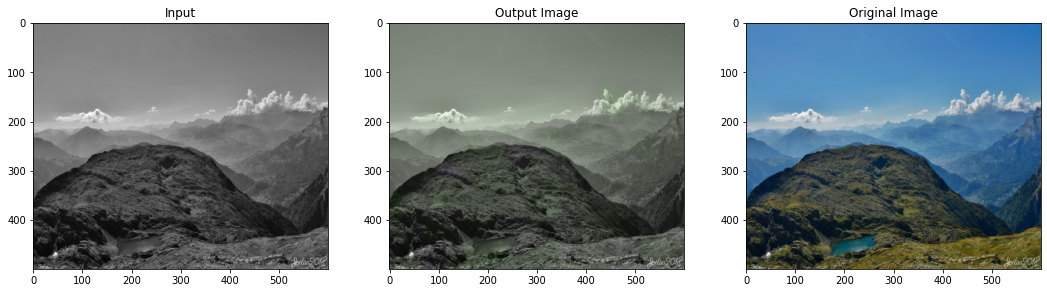

In [22]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/(18).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


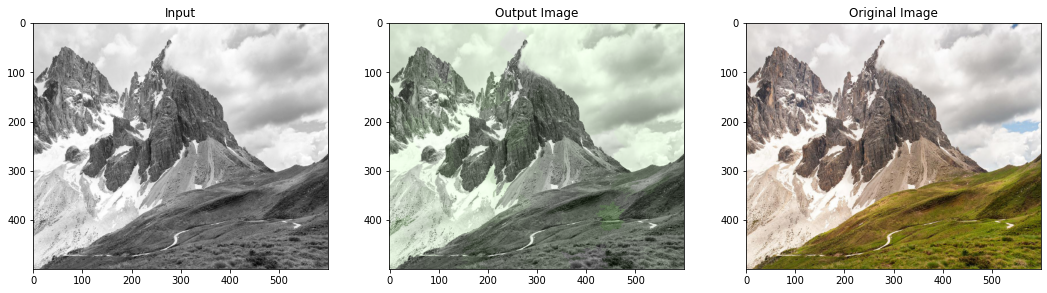

In [23]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/(25).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


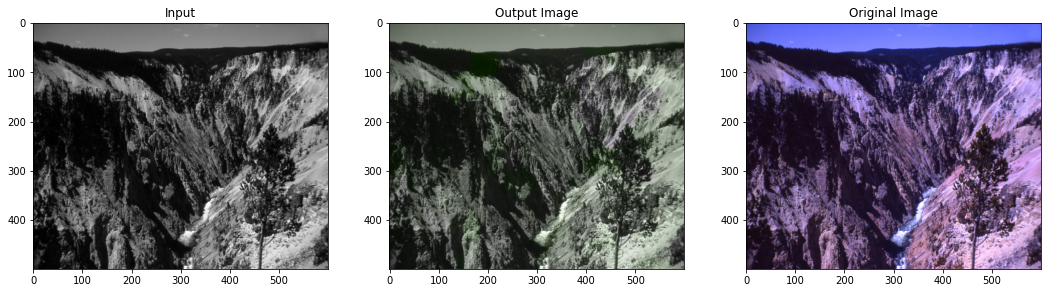

In [24]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/test/includeTrain (10).jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()

(500, 600, 3)
(500, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


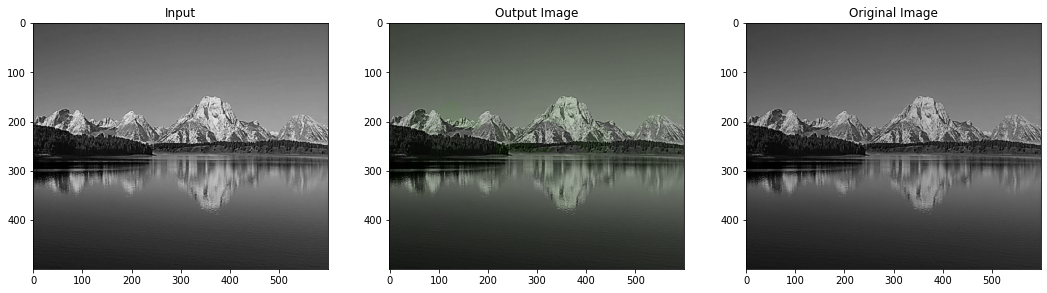

In [25]:
rgb,original=testRun(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/Test/test_2.jpg')
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes.ravel()
gray_img = rgb2gray(original)
ax[0].imshow(gray_img,  cmap=plt.cm.gray)
ax[0].set_title("Input")

ax[1].imshow(rgb)
ax[1].set_title("Output Image")

ax[2].imshow(original)
ax[2].set_title("Original Image")

fig.tight_layout()